# Introduction to Transfer Learning

In this tutorial, we will learn how to train our network using transfer learning.

In practice, very few people train an entire neural network from scratch. One of the main reasons is the lack of dataset available of sufficient size. Instead, it is common to train a network on a very large dataset and then use the trained weights to initialize and do a final 'few tweaks'.

The two important cases for transfer learning are as follows:

1. **Finetuning the network**: Use trained weights instead of random initialization.
2. **Use network as a fixed feature extractor**: We will freeze the weights for all of the network except for the final layer. This last fully connected layer is replaced with a new one with random weights.

The nice thing with this notebook is that you already have done all the hardwork. This is building on the work previously.

This tutorial is inspired by two sources: [fast.ai](fast.ai) tutorials (strongly recommend it!) and `torch` help documentation and their forums.

In [4]:
%matplotlib inline

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

Load Data
---------

We will use `torchvision` and `torch.utils.data` packages for loading the data. An example for this was shown in our previous lesson.

The problem we're going to solve today is to train a model to classify dogs belonging to two breeds - Scottish Deerhound and Maltese Dog. 

We have about ~200 training images each for dogs belonging to two breeds. There are ~60 validation images for both the classes. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

We have already extracted the data to a folder. So, we should just be able to get started with training.


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './DogBreed/Binary/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We already visualized a few images in our previous section. Ideally, all of this should be in a library. However, this is good enough for a tutorial. (So have I convinced myself!)

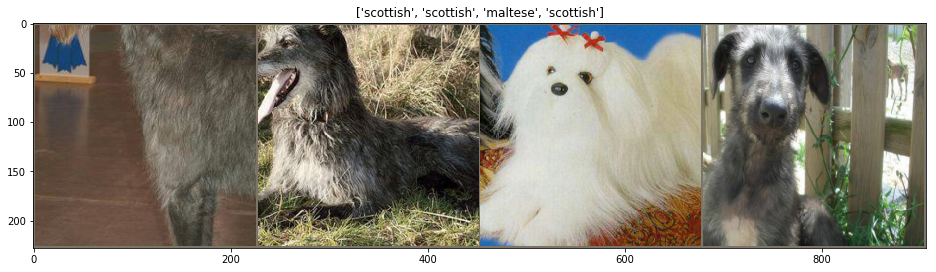

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(16,16))
imshow(out, title=[class_names[x] for x in classes])

## Training the model

In this section, let us write a general enough function to train and validate a model. We will illustrate on how to go about it.

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from ``torch.optim.lr_scheduler``.



In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('Epoch: {}/{}, Phase: {}, Loss: {:.4f} Accuracy: {:.4f}'.format(epoch, num_epochs-1, phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [1]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(16, 16))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the neural network (CNN)

Let us load a pretrained model and reset the final fully connected layer. The model architecture we are using is called `resnet18`. This [architecture](https://arxiv.org/abs/1512.03385) won the ImageNet challenge in 2015. There is a lot going on in here. So, let us carefully understand what is going on..


Let us load the model that we want to finetune. Since we are starting with a pretrained model, we are using `pretrained=True`. If you are doing it the first time, it will take some time for the weights to get downloaded.

In [12]:
model_ft = models.resnet18(pretrained=True)

In [15]:
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

512


Let us replace the last layer with a linear layer. We will get to why in a minute.

In [16]:
model_ft.fc = nn.Linear(num_ftrs, 2)

Let us also move the `model_ft` to the appropriate device. If you have a GPU and your instance of `torch` can recognize your GPU, you can run your computations on the GPU. Otherwise, CPU is your friend.

In [18]:
model_ft = model_ft.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Training and validation

So, we have done all the hardwork anyway. Let us now go ahead and train.

It should happen in a couple minutes on a GPU and around 15-20 minutes on a CPU.



In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch: 0/24, Phase: train, Loss: 0.4273 Accuracy: 0.7956
Epoch: 0/24, Phase: val, Loss: 0.0073 Accuracy: 1.0000
Epoch: 1/24, Phase: train, Loss: 0.3164 Accuracy: 0.9171
Epoch: 1/24, Phase: val, Loss: 0.0186 Accuracy: 1.0000
Epoch: 2/24, Phase: train, Loss: 0.1443 Accuracy: 0.9448
Epoch: 2/24, Phase: val, Loss: 0.0053 Accuracy: 1.0000
Epoch: 3/24, Phase: train, Loss: 0.2731 Accuracy: 0.9006
Epoch: 3/24, Phase: val, Loss: 0.0281 Accuracy: 0.9839
Epoch: 4/24, Phase: train, Loss: 0.5053 Accuracy: 0.8177
Epoch: 4/24, Phase: val, Loss: 0.0158 Accuracy: 1.0000
Epoch: 5/24, Phase: train, Loss: 0.4284 Accuracy: 0.8177
Epoch: 5/24, Phase: val, Loss: 0.2022 Accuracy: 0.9032
Epoch: 6/24, Phase: train, Loss: 0.1974 Accuracy: 0.9282
Epoch: 6/24, Phase: val, Loss: 0.0274 Accuracy: 0.9839
Epoch: 7/24, Phase: train, Loss: 0.2308 Accuracy: 0.9116
Epoch: 7/24, Phase: val, Loss: 0.0165 Accuracy: 1.0000
Epoch: 8/24, Phase: train, Loss: 0.1297 Accuracy: 0.9503
Epoch: 8/24, Phase: val, Loss: 0.0178 Accuracy:

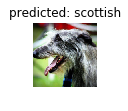

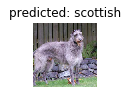

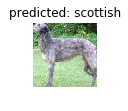

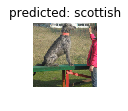

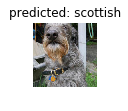

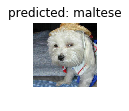

In [20]:
visualize_model(model_ft)

## CNN as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()``.

In [21]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Training and validation

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch: 0/24, Phase: train, Loss: 0.5402 Accuracy: 0.7182
Epoch: 0/24, Phase: val, Loss: 0.0277 Accuracy: 1.0000
Epoch: 1/24, Phase: train, Loss: 0.2568 Accuracy: 0.8674
Epoch: 1/24, Phase: val, Loss: 0.0105 Accuracy: 1.0000
Epoch: 2/24, Phase: train, Loss: 0.2968 Accuracy: 0.8674
Epoch: 2/24, Phase: val, Loss: 0.0127 Accuracy: 1.0000
Epoch: 3/24, Phase: train, Loss: 0.5665 Accuracy: 0.8232
Epoch: 3/24, Phase: val, Loss: 0.1673 Accuracy: 0.9032
Epoch: 4/24, Phase: train, Loss: 0.4992 Accuracy: 0.8287
Epoch: 4/24, Phase: val, Loss: 0.0034 Accuracy: 1.0000
Epoch: 5/24, Phase: train, Loss: 0.3172 Accuracy: 0.8785
Epoch: 5/24, Phase: val, Loss: 0.0036 Accuracy: 1.0000
Epoch: 6/24, Phase: train, Loss: 0.6042 Accuracy: 0.8011
Epoch: 6/24, Phase: val, Loss: 0.0224 Accuracy: 0.9839
Epoch: 7/24, Phase: train, Loss: 0.3751 Accuracy: 0.8619
Epoch: 7/24, Phase: val, Loss: 0.0018 Accuracy: 1.0000
Epoch: 8/24, Phase: train, Loss: 0.2000 Accuracy: 0.9227
Epoch: 8/24, Phase: val, Loss: 0.0029 Accuracy:

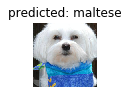

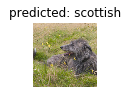

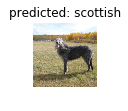

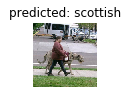

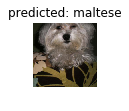

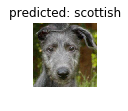

In [23]:
visualize_model(model_conv)